## IMPORTS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from metrics.overallscore import calculate_overall_score
from metrics.dataquality import calculate_data_quality_metrics
from metrics.dataquality import calculate_phone_number_metrics
from metrics.dataquality import calculate_email_metrics
from metrics.dataquality import calculate_average_metrics
from metrics.overallscore import calculate_overall_score_mom
from metrics.datacollectorscore import calculate_quality_score_by_collector

## READING DATA

In [2]:
# data = pd.read_csv("data/ecg/customers_sep_nov.csv")
data = pd.read_csv("data/ecg/customers_v2_jan_2024.csv")
data_v2 = pd.read_csv("data/ecg/customers_v2_.csv")

In [3]:
column_mapping = {
    'slrn': 'SLRN',
    'ac_no': 'Account Number',
    'meter_number': 'Meter Number',
    'meter_status': 'Meter Status',
    'meter_slrn': 'Meter SLRN',
    'phone_number': 'Phone Number',
    'email': 'Email',
    'date': 'Date',
    'first_captured_username': 'First Captured Username',
    'updated_username': 'Updated Username'
}
data_x = data.copy()
data_x.rename(columns=column_mapping, inplace=True)

In [4]:
filtered_data_ecg = data_x[data_x['SLRN'].str.startswith('ECG')]

In [5]:
df = filtered_data_ecg.copy()

## METRICS

In [6]:
# List to store metrics for each key field
metrics_list = []

# Calculate metrics for each key field
key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN', 'Phone Number', 'Email']

for field_name in key_fields:
    if field_name in df.columns:
        if field_name in ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN']:
            metrics = calculate_data_quality_metrics(df, field_name, 'ECGBD', 12, 'ECGCR', 11)
        elif field_name == 'Phone Number':
            metrics = calculate_phone_number_metrics(df, field_name, 'ECGBD', corresponding_meter_field='Meter Number')
        elif field_name == 'Email':
            metrics = calculate_email_metrics(df, field_name, corresponding_meter_field='Meter Number')
        
        metrics_list.append(metrics)

# Calculate average completeness, validity, and integrity
average_completeness = calculate_average_metrics(metrics_list, 'Completeness')
average_validity = calculate_average_metrics(metrics_list, 'Validity')
average_integrity = calculate_average_metrics(metrics_list, 'Integrity')

# Calculate overall score using the overall_score function
overall_score = calculate_overall_score(average_completeness, average_validity, average_integrity)

total_caims_data = df['Meter Number'].nunique()
print(f'\nSample Data: {total_caims_data:,}')

# Display the results
print("\nQuality Metrics for Each Field:")
for field_name in key_fields:
    if field_name in df.columns:
        print(f"\nMetrics for {field_name}:")
        print(f"Completeness: {metrics_list[key_fields.index(field_name)]['Completeness']:.2f}%")
        print(f"Validity: {metrics_list[key_fields.index(field_name)]['Validity']:.2f}%")
        print(f"Integrity: {metrics_list[key_fields.index(field_name)]['Integrity']:.2f}%")
        
        # Calculate and print the overall score for each field
        field_overall_score = calculate_overall_score(
            metrics_list[key_fields.index(field_name)]['Completeness'],
            metrics_list[key_fields.index(field_name)]['Validity'],
            metrics_list[key_fields.index(field_name)]['Integrity']
        )
        print(f"Overall Score: {field_overall_score:.2f}")

print("\nQuality Metrics - Average and Overall Score:")
print(f"Average Completeness: {average_completeness:.2f}%")
print(f"Average Validity: {average_validity:.2f}%")
print(f"Average Integrity: {average_integrity:.2f}%")
print(f"Overall Score: {overall_score:.2f}")



Sample Data: 1,134,027

Quality Metrics for Each Field:

Metrics for SLRN:
Completeness: 100.00%
Validity: 99.90%
Integrity: 99.99%
Overall Score: 100.00

Metrics for Account Number:
Completeness: 85.47%
Validity: 80.47%
Integrity: 85.09%
Overall Score: 83.60

Metrics for Meter Number:
Completeness: 99.61%
Validity: 98.95%
Integrity: 67.95%
Overall Score: 92.80

Metrics for Meter SLRN:
Completeness: 99.49%
Validity: 99.34%
Integrity: 99.47%
Overall Score: 100.00

Metrics for Phone Number:
Completeness: 84.78%
Validity: 77.37%
Integrity: 72.15%
Overall Score: 79.20

Metrics for Email:
Completeness: 40.72%
Validity: 14.33%
Integrity: 1.13%
Overall Score: 22.00

Quality Metrics - Average and Overall Score:
Average Completeness: 85.01%
Average Validity: 78.39%
Average Integrity: 70.96%
Overall Score: 79.60


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year Month'] = df['Date'].dt.to_period('M')
df['date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
df["date"] = df.date.astype(str)
df["year_month"] = df.date.str[0:7]
df["year_month"] = df.year_month.str.replace('-', '')
df["year_month"] = df.year_month.apply(lambda x: int(x) if str(x).isdigit() else 0)

In [8]:
def calculate_unique_meter_count(df, date_column, meter_number_column):
    unique_meter_count = df.groupby(date_column)[meter_number_column].nunique().reset_index()
    unique_meter_count.columns = [date_column, 'Unique Meter Count']
    return unique_meter_count

# Compute unique meter count
unique_meter_count_df = calculate_unique_meter_count(df, 'Year Month', 'Meter Number')


# Calculate overall data quality score on a monthly basis and link it back to the DataFrame
mom_overall_score = calculate_overall_score_mom(df)
mom_overall_score_fil = mom_overall_score[mom_overall_score['year_month'] >= 202301]
mom_overall_score_fil = mom_overall_score_fil[['Year Month', 'Overall Score', 'year_month']]
mom_overall_score_fil = mom_overall_score_fil.sort_values(by='year_month', ascending=True)
mom_overall_score_fil = mom_overall_score_fil.drop_duplicates(subset=['Year Month'])

mom_overall_score_fil = pd.merge(mom_overall_score_fil, unique_meter_count_df, on='Year Month', how='left')

## MOM CHART

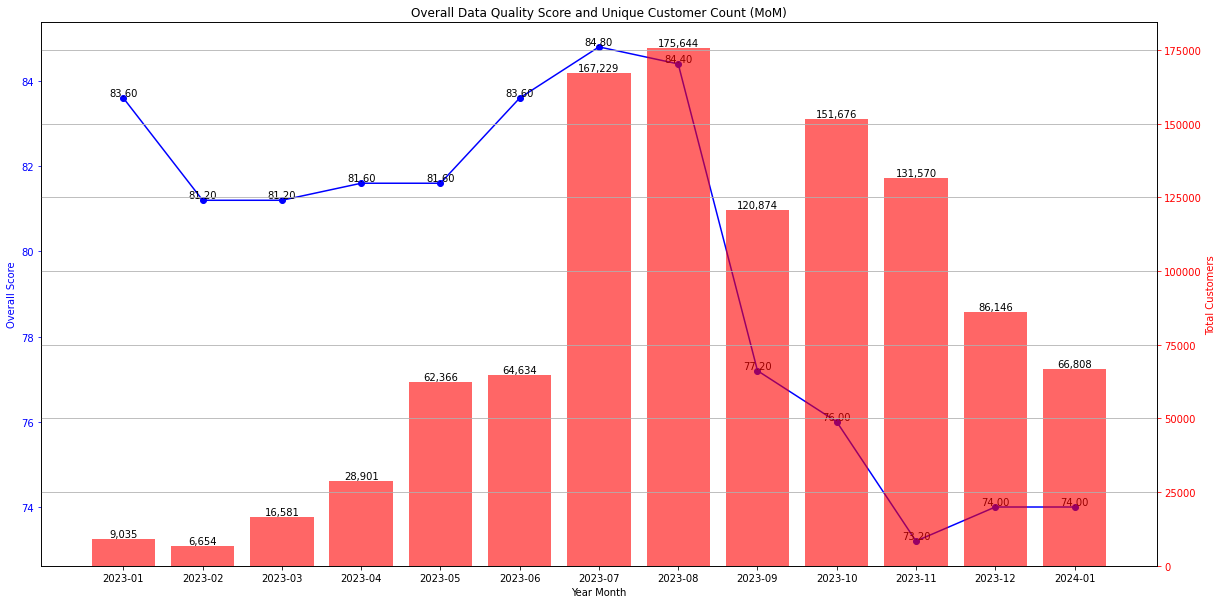

In [9]:
# Plot overall data quality score on a MoM basis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the overall score on the primary y-axis
ax1.plot(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Overall Score'].round(2), marker='o', linestyle='-', color='b', label='Overall Score')
ax1.set_xlabel('Year Month')
ax1.set_ylabel('Overall Score', color='b')
ax1.tick_params('y', colors='b')

# Text annotations
for i, txt in enumerate(mom_overall_score_fil['Overall Score'].round(2)):
    ax1.text(mom_overall_score_fil['Year Month'].astype(str).iloc[i], txt, f'{txt:.2f}', ha='center', va='bottom')

# Secondary y-axis for the count of unique meter numbers
ax2 = ax1.twinx()
bars = ax2.bar(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Unique Meter Count'], alpha=0.6, color='red', label='Unique Meter Count')
ax2.set_ylabel('Total Customers', color='r')
ax2.tick_params('y', colors='r')

# Add labels on the bar chart with MoM figures
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', va='bottom', ha='center')

# Show the plot
plt.title('Overall Data Quality Score and Unique Customer Count (MoM)')
plt.grid(True)
plt.show()


In [ ]:
mom_overall_score_fil[['Year Month', 'Overall Score']].to_csv('data/exports/mom_overall_score_dec_2023.csv', index=False)

In [ ]:
mom_overall_score_fil

,Year Month,Overall Score,year_month,Unique Meter Count
0,2023-01,83.6,202301,9035
1,2023-02,81.2,202302,6654
2,2023-03,80.4,202303,16581
3,2023-04,81.6,202304,28901
4,2023-05,81.6,202305,62366
5,2023-06,83.6,202306,64634
6,2023-07,84.8,202307,167229
7,2023-08,84.4,202308,175644
8,2023-09,77.2,202309,120874
9,2023-10,76.0,202310,151676


In [10]:
import pandas as pd

def calculate_metrics_by_month(df, key_fields):
    result_data = []

    for year_month in df['Year Month'].unique():
        # Filter the DataFrame for the current year_month
        df_month = df[df['Year Month'] == year_month]
        
        # Calculate metrics for the current month
        metrics_list = []

        for field_name in key_fields:
            if field_name in df.columns:
                if field_name in ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN']:
                    metrics = calculate_data_quality_metrics(df_month, field_name, 'ECGBD', 12, 'ECGCR', 11)
                elif field_name == 'Phone Number':
                    metrics = calculate_phone_number_metrics(df_month, field_name, 'ECGBD', corresponding_meter_field='Meter Number')
                elif field_name == 'Email':
                    metrics = calculate_email_metrics(df_month, field_name, corresponding_meter_field='Meter Number')

                metrics_list.append(metrics)

        average_completeness = calculate_average_metrics(metrics_list, 'Completeness')
        average_validity = calculate_average_metrics(metrics_list, 'Validity')
        average_integrity = calculate_average_metrics(metrics_list, 'Integrity')
        overall_score = calculate_overall_score(average_completeness, average_validity, average_integrity)

        unique_meter_count = calculate_unique_meter_count(df_month, 'Year Month', 'Meter Number')['Unique Meter Count'].iloc[0]

        # Construct dictionaries for each metric type
        metrics_data = []
        for field_name in key_fields:
            metrics_data.append({'Year Month': year_month, 'Metrics': 'Completeness', field_name: metrics_list[key_fields.index(field_name)]['Completeness']})
            metrics_data.append({'Year Month': year_month, 'Metrics': 'Validity', field_name: metrics_list[key_fields.index(field_name)]['Validity']})
            metrics_data.append({'Year Month': year_month, 'Metrics': 'Integrity', field_name: metrics_list[key_fields.index(field_name)]['Integrity']})

        metrics_data.append({'Year Month': year_month, 'Metrics': 'Overall Score', **{field_name: overall_score for field_name in key_fields}})
        metrics_data.append({'Year Month': year_month, 'Metrics': 'Unique Meter Count', **{field_name: unique_meter_count for field_name in key_fields}})

        # Append metrics data to the result list
        result_data.extend(metrics_data)

    # Convert the list of dictionaries to a DataFrame
    result_df = pd.DataFrame(result_data)
    
    return result_df

key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN', 'Phone Number', 'Email']

result_table = calculate_metrics_by_month(df, key_fields)


In [12]:
result_table

,Year Month,Metrics,SLRN,Account Number,Meter Number,Meter SLRN,Phone Number,Email
0,2023-10,Completeness,100.000000,NaN,NaN,NaN,NaN,NaN
1,2023-10,Validity,99.891480,NaN,NaN,NaN,NaN,NaN
2,2023-10,Integrity,99.970758,NaN,NaN,NaN,NaN,NaN
3,2023-10,Completeness,NaN,68.128326,NaN,NaN,NaN,NaN
4,2023-10,Validity,NaN,67.594175,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
355,2023-12,Completeness,NaN,NaN,NaN,NaN,NaN,0.607515
356,2023-12,Validity,NaN,NaN,NaN,NaN,NaN,0.604423
357,2023-12,Integrity,NaN,NaN,NaN,NaN,NaN,0.601718
358,2023-12,Overall Score,73.200000,73.200000,73.2,73.2,73.2,73.200000


In [ ]:
result_table.to_csv('mom_metrics__ji.csv', index=False)

In [ ]:
jan_df = df[df['Date'] > '2023-12-31']
dec_df = df[df['year_month'] == 202312]

In [ ]:
dec_df.to_csv('dec_df.csv', index=False)

## QUALITY SCORE BY DATA COLLECTOR

In [ ]:
df_x = df[df['year_month'] >= 202311]

field_metrics = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN', 'Phone Number', 'Email']

collector_scores = calculate_quality_score_by_collector(df_x, field_metrics)

collector_scores


,Average Completeness,Average Validity,Average Integrity,Overall Average
RolandA,40.00%,40.00%,40.00%,40.00%
AsieduS,40.00%,40.00%,40.00%,40.00%
CharlesA,37.78%,37.78%,36.67%,37.41%
Abugaemmanuel,36.67%,36.67%,36.67%,36.67%
ErnestKabu,36.88%,36.60%,36.28%,36.59%
...,...,...,...,...
StephanieOwusu,24.71%,24.00%,21.18%,23.29%
EnochOsei,24.03%,23.53%,21.55%,23.04%
JenniferNdinga,23.05%,22.92%,22.79%,22.92%
PeterBernasko,21.25%,21.17%,20.83%,21.08%


In [ ]:
collector_scores.to_csv('data/exports/collectors_score_dec_2023.csv', index=True)